In [1]:
#these models are designed to run on mobile phones with way fewer parameters (W,b)
# They arent as accurate as the bigger model

#import relevant libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils

from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
%matplotlib inline

In [2]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [3]:
def prepare_image(file):
    img_path = 'data/MobileNet-samples/'
    img = image.load_img(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

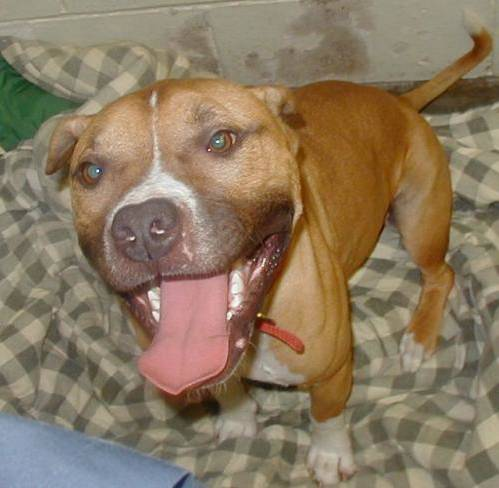

In [4]:
from IPython.display import Image
#for one random image 
Image(filename='data/MobileNet-samples/dog.6.jpg', width=300, height=200)

In [5]:
preprocessed_img = prepare_image('dog.6.jpg')
predictions = mobile.predict(preprocessed_img)
results = imagenet_utils.decode_predictions(predictions)
results

[[('n02093428', 'American_Staffordshire_terrier', 0.69491076),
  ('n02093256', 'Staffordshire_bullterrier', 0.28876835),
  ('n02108089', 'boxer', 0.0054507973),
  ('n02100583', 'vizsla', 0.005092169),
  ('n02087394', 'Rhodesian_ridgeback', 0.0016628893)]]

In [10]:
#break the data into the train-test-split
os.chdir('data/Sign-Language-Digits-Dataset')
if os.path.isdir('train/0/')is False :
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0,10):
        shutil.move(f'{i}','train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')        
        
        valid_samples = random.sample(os.listdir(f'train/{i}'), 30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')
                        
        test_samples = random.sample(os.listdir(f'train/{i}'), 5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')  
            
os.chdir('../../')
        

In [11]:
train_path='data/Sign-Language-Digits-Dataset/train'
valid_path='data/Sign-Language-Digits-Dataset/valid'
test_path='data/Sign-Language-Digits-Dataset/test'

In [17]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
.flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
.flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input) \
.flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 1682 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


In [18]:
# Fine tuning mobile net for a custom dataset
mobile = tf.keras.applications.mobilenet.MobileNet()
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [19]:
x = mobile.layers[-6].output
output = Dense(units=10, activation='softmax')(x)

In [21]:
model = Model(inputs=mobile.input, outputs=output)

In [22]:
for layers in model.layers[:-23]: # freezing all but the last 23 - make them not trainable
    layers.trainable = False
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [23]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
169/169 - 136s - loss: 0.6215 - accuracy: 0.8276 - val_loss: 0.4750 - val_accuracy: 0.8200
Epoch 2/10
169/169 - 151s - loss: 0.1059 - accuracy: 0.9863 - val_loss: 0.1386 - val_accuracy: 0.9533
Epoch 3/10
169/169 - 108s - loss: 0.0561 - accuracy: 0.9941 - val_loss: 0.0903 - val_accuracy: 0.9667
Epoch 4/10
169/169 - 106s - loss: 0.0394 - accuracy: 0.9935 - val_loss: 0.0559 - val_accuracy: 0.9867
Epoch 5/10
169/169 - 106s - loss: 0.0201 - accuracy: 1.0000 - val_loss: 0.0573 - val_accuracy: 0.9833
Epoch 6/10
169/169 - 106s - loss: 0.0167 - accuracy: 0.9988 - val_loss: 0.0564 - val_accuracy: 0.9767
Epoch 7/10
169/169 - 107s - loss: 0.0141 - accuracy: 0.9988 - val_loss: 0.0488 - val_accuracy: 0.9900
Epoch 8/10
169/169 - 105s - loss: 0.0112 - accuracy: 0.9988 - val_loss: 0.0430 - val_accuracy: 0.9833
Epoch 9/10
169/169 - 105s - loss: 0.0078 - accuracy: 1.0000 - val_loss: 0.0349 - val_accuracy: 0.9833
Epoch 10/10
169/169 - 105s - loss: 0.0096 - accuracy: 0.9988 - val_loss: 0.0536 - 

In [27]:
test_labels = test_batches.classes

In [30]:
predictions = model.predict(x=test_batches, verbose=0)

In [31]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [34]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9}

In [35]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    THis function prints and plots the confusion matrix
    Normalization cn be applied by setting `normalize=True`
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix without normalization')
        
    print(cm)
    
    tresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(i,j,cm[i,j],
                    horizontalalignment="center",
                    color="white" if cm[i,j] > tresh else "black")
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

Confusion matrix without normalization
[[5 0 0 0 0 0 0 0 0 0]
 [0 5 0 0 0 0 0 0 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 5 0 0 0]
 [0 0 0 0 0 0 0 4 1 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]


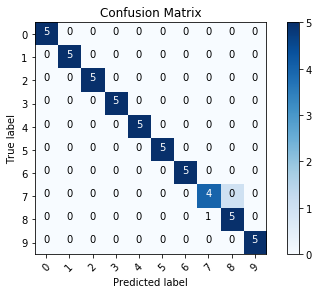

In [36]:
cm_plot_labels = ['0','1','2','3','4','5','6','7','8','9']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')